# ResNet34 residual - Tensorflow/Keras - Mnist


## Imports

In [1]:
import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [3]:
!pip freeze | grep -e "tensorflow==" -e "keras=="

keras==2.10.0


In [4]:
import tensorflow as tf

from tensorflow.keras import layers, Model, Input, callbacks
from tensorflow.keras.regularizers import L2

2023-01-24 18:01:59.105419: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-24 18:01:59.184855: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-24 18:01:59.547118: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-24 18:01:59.547157: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [5]:
from sklearn.model_selection import train_test_split

from tqdm.keras import TqdmCallback

In [6]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print(f'Found GPU: {device_name}')

Found GPU: /device:GPU:0


2023-01-24 18:02:00.239663: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-24 18:02:00.269406: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-24 18:02:00.283722: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-24 18:02:00.283904: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
import numpy as np

## Load and prepare data

In [9]:
# Load data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()

In [10]:
no_classes = 100

In [11]:
# Normalize pixel values to be between 0 and 1
x_train = x_train / 255.0
x_test = x_test / 255.0

y_train_one_hot = tf.keras.utils.to_categorical(y_train, no_classes)
y_test_one_hot = tf.keras.utils.to_categorical(y_test, no_classes)

In [12]:
# Fixing seed for Python, NumPy, and TensorFlow
seed = 0
tf.keras.utils.set_random_seed(seed)

In [13]:
# Split train val
x_train, x_val, y_train_one_hot, y_val_one_hot = train_test_split(x_train, y_train_one_hot, test_size=.2, random_state=0)

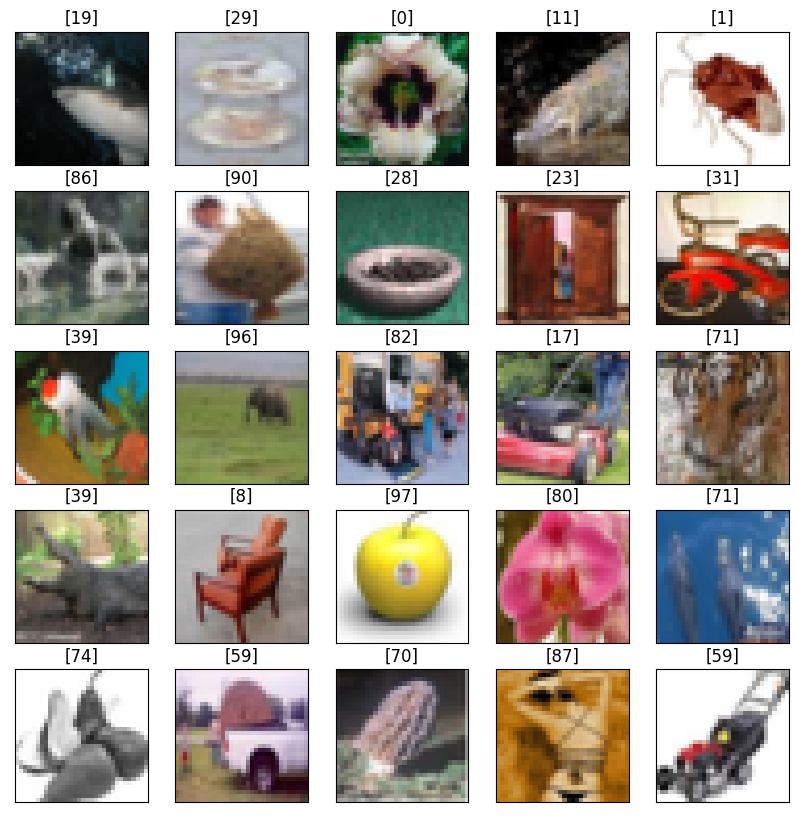

In [14]:
# Plot grid with first 25 training images with their corresponding label
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[i].squeeze(), cmap='gray')
    plt.title(y_train[i])
plt.show()

## Defining a training class

## Building architecture then model

In [15]:
batch_size = 512
epochs = 250
dropout_rate = .25
regularization_coef = .001

In [16]:
def IdentityBlock(X, kernel_size, filters):
    F1, F2, F3 = filters
    X_shortcut = X
    
    X = layers.Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=L2(regularization_coef))(X)
    X = layers.BatchNormalization()(X)
    X = layers.Activation('elu')(X)
    
    X = layers.Conv2D(filters=F2, kernel_size=(kernel_size, kernel_size), strides=(1, 1), padding='same', kernel_regularizer=L2(regularization_coef))(X)
    X = layers.BatchNormalization()(X)
    X = layers.Activation('elu')(X)
    
    X = layers.Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='same', kernel_regularizer=L2(regularization_coef))(X)
    X = layers.BatchNormalization()(X)
    
    X = layers.Add()([X, X_shortcut])
    X = layers.Activation('elu')(X)
    
    return X

def ConvBlock(X, kernel_size, filters):
    F1, F2, F3 = filters
    X_shortcut = X
    
    X = layers.Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_regularizer=L2(regularization_coef))(X)
    X = layers.BatchNormalization()(X)
    X = layers.Activation('elu')(X)
    
    X = layers.Conv2D(filters=F2, kernel_size=(kernel_size, kernel_size), strides=(1, 1), padding='same', kernel_regularizer=L2(regularization_coef))(X)
    X = layers.BatchNormalization()(X)
    X = layers.Activation('elu')(X)
    
    X = layers.Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='same', kernel_regularizer=L2(regularization_coef))(X)
    X = layers.BatchNormalization()(X)
    
    X_shortcut = layers.Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='same', kernel_regularizer=L2(regularization_coef))(X_shortcut)
    X_shortcut = layers.BatchNormalization()(X_shortcut)
    
    X = layers.Add()([X, X_shortcut])
    X = layers.Activation('elu')(X)
    
    return X

def get_resnet(input_shape=(224, 224, 3)):
    X_input = layers.Input(input_shape)
    X = layers.ZeroPadding2D((3,3))(X_input)

    X = layers.Conv2D(filters=64, kernel_size=(7, 7), strides=(2, 2), padding='same', kernel_regularizer=L2(regularization_coef))(X_input)
    X = layers.BatchNormalization()(X)
    X = layers.Activation('relu')(X)
    X = layers.MaxPooling2D((3, 3))(X)
    
    X = layers.ZeroPadding2D((1,1))(X)
    X = layers.MaxPooling2D(pool_size=(3, 3), strides=(2,2))(X)
    
    X = ConvBlock(X, kernel_size=3, filters=[64, 128, 256])
    X = IdentityBlock(X, kernel_size=3, filters=[64, 128, 256])
    X = layers.Dropout(dropout_rate)(X)
    X = layers.AveragePooling2D((2, 2))(X)
    
    X = layers.Flatten()(X)
    X = layers.Dense(1024)(X)
    X = layers.Activation('elu')(X)
    X = layers.Dense(no_classes)(X)
    X_output = layers.Softmax()(X)
    return Model(inputs=[X_input], outputs=[X_output], name='Resnet34-residual')

In [17]:
img_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3])
img_shape

(32, 32, 3)

In [18]:
# Define model, for a fully-connected network the input must be properly adapted
model = get_resnet(img_shape)

# Set hyperparameters
loss_function=tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()
metric = tf.keras.metrics.SparseCategoricalCrossentropy(name='test_acc')
callbacks=[
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=50),
    TqdmCallback(verbose=0)
]

# Initialize trainer
model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

# Train model
start_time = time.time()

results = model.fit(
    x_train, y_train_one_hot, batch_size, epochs, 
    validation_data=(x_val, y_val_one_hot),
    callbacks=callbacks,
    verbose=0 # Supress fitting information
)

predictions = model.predict(x_test)
metric(y_test, predictions)
print(f'Execution time: {round(time.time() - start_time, 2)}s - Test accuracy: {metric.result()*10.:.2f}')

2023-01-24 18:02:01.887514: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-24 18:02:01.887726: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-24 18:02:01.887859: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-24 18:02:01.888119: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-24 18:02:01.888258: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

0epoch [00:00, ?epoch/s]

2023-01-24 18:02:03.787005: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8600


313/313 [==============================] - 1s 2ms/step
Execution time: 89.96s - Test accuracy: 51.00


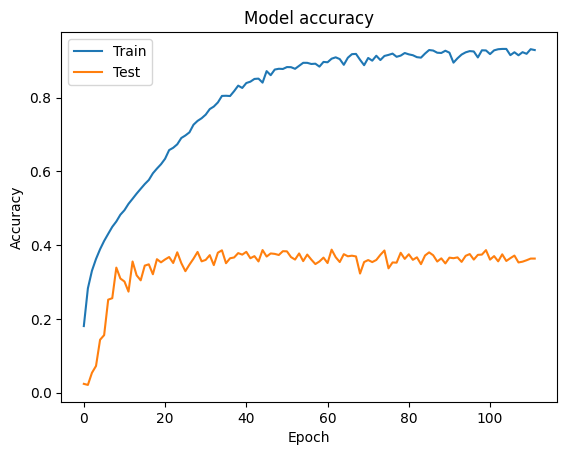

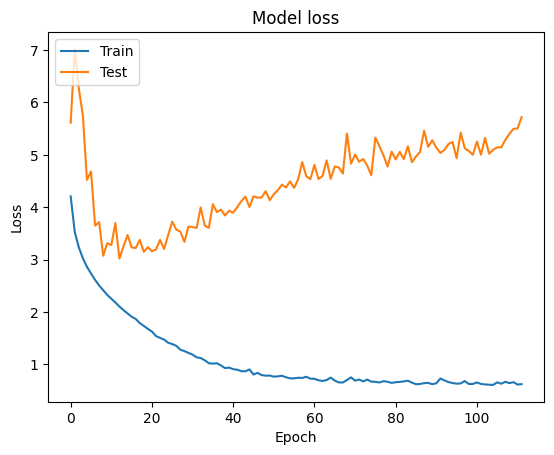

In [19]:
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()